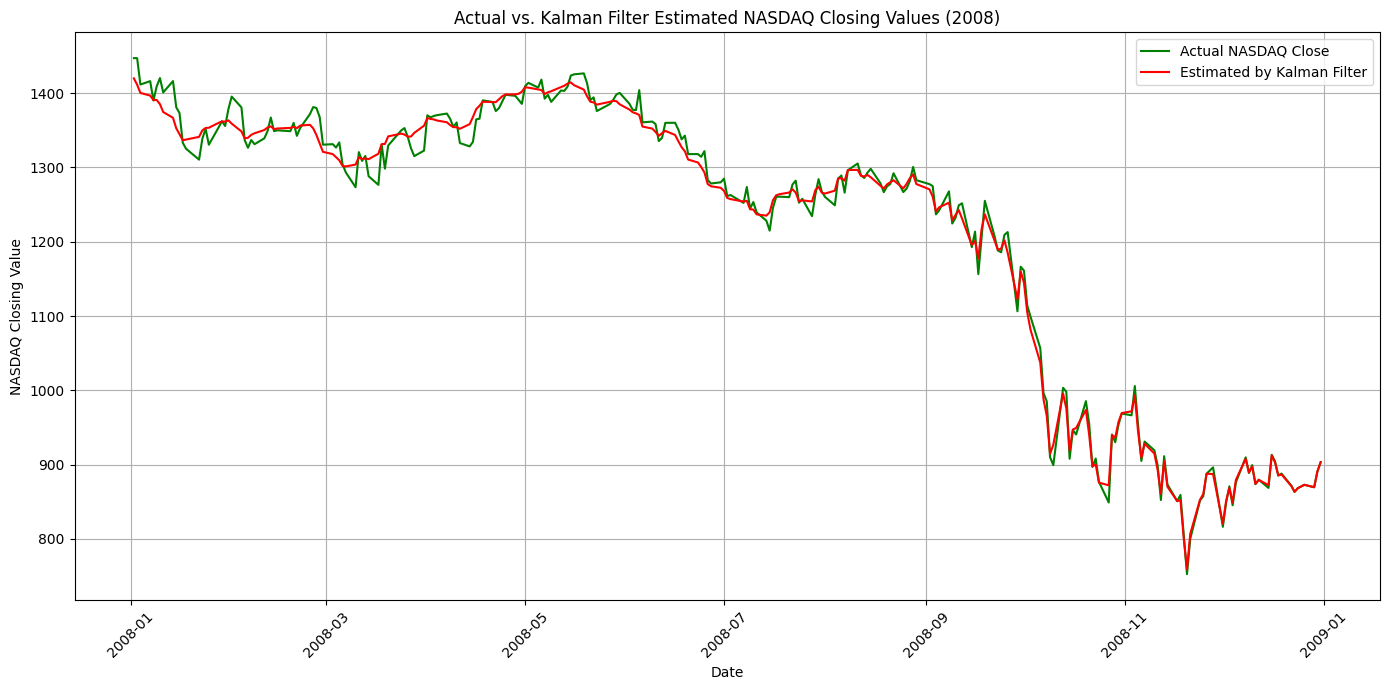

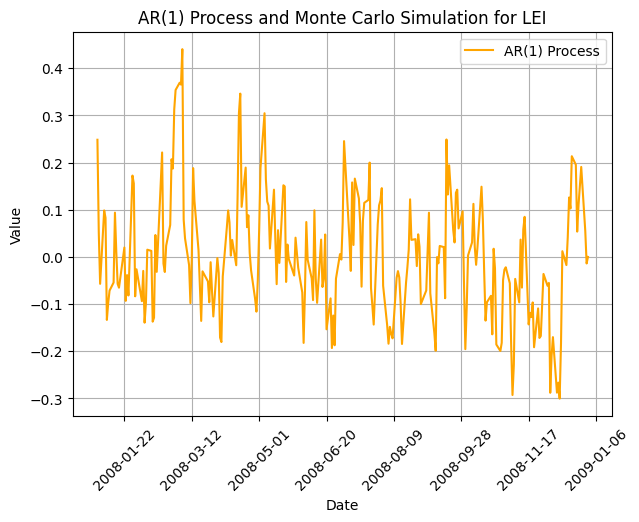

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class AdaptiveKalmanFilter:
    def __init__(self, beta_initial, P_initial, Q_initial, R_initial, adapt_rate=0.01):
        self.beta = beta_initial
        self.P = P_initial
        self.Q = Q_initial
        self.R = R_initial
        self.adapt_rate = adapt_rate

    def update(self, y):
        # Prediction
        beta_predicted = self.beta
        P_predicted = self.P + self.Q

        # Innovation
        innovation = y - beta_predicted
        innovation_variance = P_predicted + self.R

        # Update Q and R adaptively based on innovation
        self.Q = (1 - self.adapt_rate) * self.Q + self.adapt_rate * (innovation ** 2)
        self.R = (1 - self.adapt_rate) * self.R + self.adapt_rate * innovation_variance

        # Kalman Gain
        K = P_predicted / innovation_variance
        self.beta = beta_predicted + K * innovation
        self.P = (1 - K) * P_predicted

        return self.beta

# Load and prepare NASDAQ data
nasdaq_data = pd.read_csv("NasdaqData.csv")
nasdaq_data['Close'] = nasdaq_data['Close'].str.replace(',', '').astype(float)
nasdaq_data['Date'] = pd.to_datetime(nasdaq_data['Date'])
nasdaq_data_2008 = nasdaq_data[nasdaq_data['Date'].dt.year == 2008]

# Kalman Filter Initialization
beta_initial = nasdaq_data_2008['Close'].iloc[0]  # Starting with the first closing value
P_initial = 1.0
Q = 0.0001
R = 0.001  # Smaller measurement noise, assuming closing prices are reliable
adapt_rate = 0.02  # Slightly higher adaptation rate to react to market changes quickly

kalman_filter = AdaptiveKalmanFilter(beta_initial, P_initial, Q, R, adapt_rate)

# Use actual NASDAQ data to update Kalman Filter
estimated_betas = [beta_initial]
for price in nasdaq_data_2008['Close'][1:]:
    estimated_beta = kalman_filter.update(price)
    estimated_betas.append(estimated_beta)

# Plot actual vs predicted results
plt.figure(figsize=(14, 7))
plt.plot(nasdaq_data_2008['Date'], nasdaq_data_2008['Close'], label='Actual NASDAQ Close', color='green')
plt.plot(nasdaq_data_2008['Date'], estimated_betas, label='Estimated by Kalman Filter', color='red')
plt.xlabel('Date')
plt.ylabel('NASDAQ Closing Value')
plt.title('Actual vs. Kalman Filter Estimated NASDAQ Closing Values (2008)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot AR(1) process
plt.plot(nasdaq_dates, X_ar, label='AR(1) Process', color='orange')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('AR(1) Process and Monte Carlo Simulation for LEI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Set maximum number of x-axis labels to display
plt.show()